In [1]:
import socket
import hmac
import numpy as np
from PIL import Image

def combine_pixel_groups_into_image(groups):
    combined_image = Image.new('RGB', (1979,1180 ))
    x = 0
    y = 0
    for i in sorted(groups.keys()):
        combined_image.paste(groups[i], (x, y, x + groups[i].width, y + groups[i].height))
        x += groups[i].width
        if x >= 1979:
            x = 0
            y += groups[i].height

    return combined_image

def validate(chunks):
    res = {}
    total_Verified_Data_Length = 0
    for i in chunks.keys():
         # Verify the HMAC
        if hmac.new(b'key', chunks[i][0], 'sha384').digest() != chunks[i][1]:
            res[i] = Image.new("RGB", (5, 6), (255, 0, 0))
            continue
        else:
            res[i] = chunks[i][0]
            total_Verified_Data_Length += len(chunks[i][0])
    return res, total_Verified_Data_Length

def receive_raw_image(output_path, ip, port):
    # Create a UDP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.bind((ip, port))

    print(f"Listening on port {port} for  image...")

    chunk_size =4096
    chunks = {}
    expected_chunk_index = 0

    total_MAC_Length = 0
    total_Data_Length = 0
    total_Verified_Data_Length = 0

    while True:
        data, addr = sock.recvfrom(chunk_size+ 4 + 48)  # 8 bytes for index + 1024 bytes of data
        if data == b'END':
            break

        # Extract the chunk index and chunk data
        chunk_index = int.from_bytes(data[:4], 'big')
        chunk_data = data[4:-48]
        mac = data[-48:]

        total_MAC_Length += len(mac)
        total_Data_Length += len(chunk_data)



        if hmac.new(b'key', chunk_data, 'sha384').digest() != mac:
            chunks[chunk_index] = Image.new("RGB", (5, 6), (255, 0, 0))
            continue
        else:
            total_Verified_Data_Length += len(chunk_data)
            chunks[chunk_index] = Image.fromarray(np.frombuffer(chunk_data, dtype=np.uint8).reshape((6, 5, 3)))

        # chunks,total_Verified_Data_Length = validate(chunks)



       
        # print(f"Received chunk {chunk_index} from {addr}")

    for i in range(78012):
        if i not in chunks.keys():
            print(f"Missing chunk {i}")
            chunks[i] = Image.new("RGB", (5, 6), (0, 0, 0))
            total_Data_Length += len(chunks[i].tobytes())
            total_MAC_Length += len(mac)
        # else:
        #     chunks[i] = Image.fromarray(np.frombuffer(chunk_data, dtype=np.uint8).reshape((6, 5, 3)))
        
    # Reassemble the chunks
    with open(output_path, 'wb') as f:
        for i in sorted(chunks.keys()):
            f.write(chunks[i].tobytes())

    print(f"BMP image saved to {output_path}")
    print('message size: ',len(chunk_data)*8,',\nMAC size: ', len(mac)*8)
    return chunks , total_Verified_Data_Length/(total_Data_Length + total_MAC_Length)

# Example usage
output_path = 'received_image.NEF'
server_ip = '0.0.0.0'
listen_port = 23423
chunks, authenticated_Goodput = receive_raw_image(output_path, server_ip, listen_port)
print(f"Authenticated Goodput: {authenticated_Goodput:.2%}")

Listening on port 23423 for  image...
Missing chunk 14
Missing chunk 54
Missing chunk 60
Missing chunk 108
Missing chunk 159
Missing chunk 226
Missing chunk 279
Missing chunk 290
Missing chunk 350
Missing chunk 366
Missing chunk 411
Missing chunk 434
Missing chunk 445
Missing chunk 472
Missing chunk 500
Missing chunk 513
Missing chunk 521
Missing chunk 525
Missing chunk 539
Missing chunk 544
Missing chunk 639
Missing chunk 664
Missing chunk 677
Missing chunk 700
Missing chunk 726
Missing chunk 764
Missing chunk 772
Missing chunk 800
Missing chunk 802
Missing chunk 807
Missing chunk 847
Missing chunk 849
Missing chunk 870
Missing chunk 876
Missing chunk 890
Missing chunk 892
Missing chunk 932
Missing chunk 946
Missing chunk 955
Missing chunk 1021
Missing chunk 1022
Missing chunk 1028
Missing chunk 1038
Missing chunk 1041
Missing chunk 1043
Missing chunk 1068
Missing chunk 1069
Missing chunk 1097
Missing chunk 1129
Missing chunk 1144
Missing chunk 1165
Missing chunk 1219
Missing chunk 12

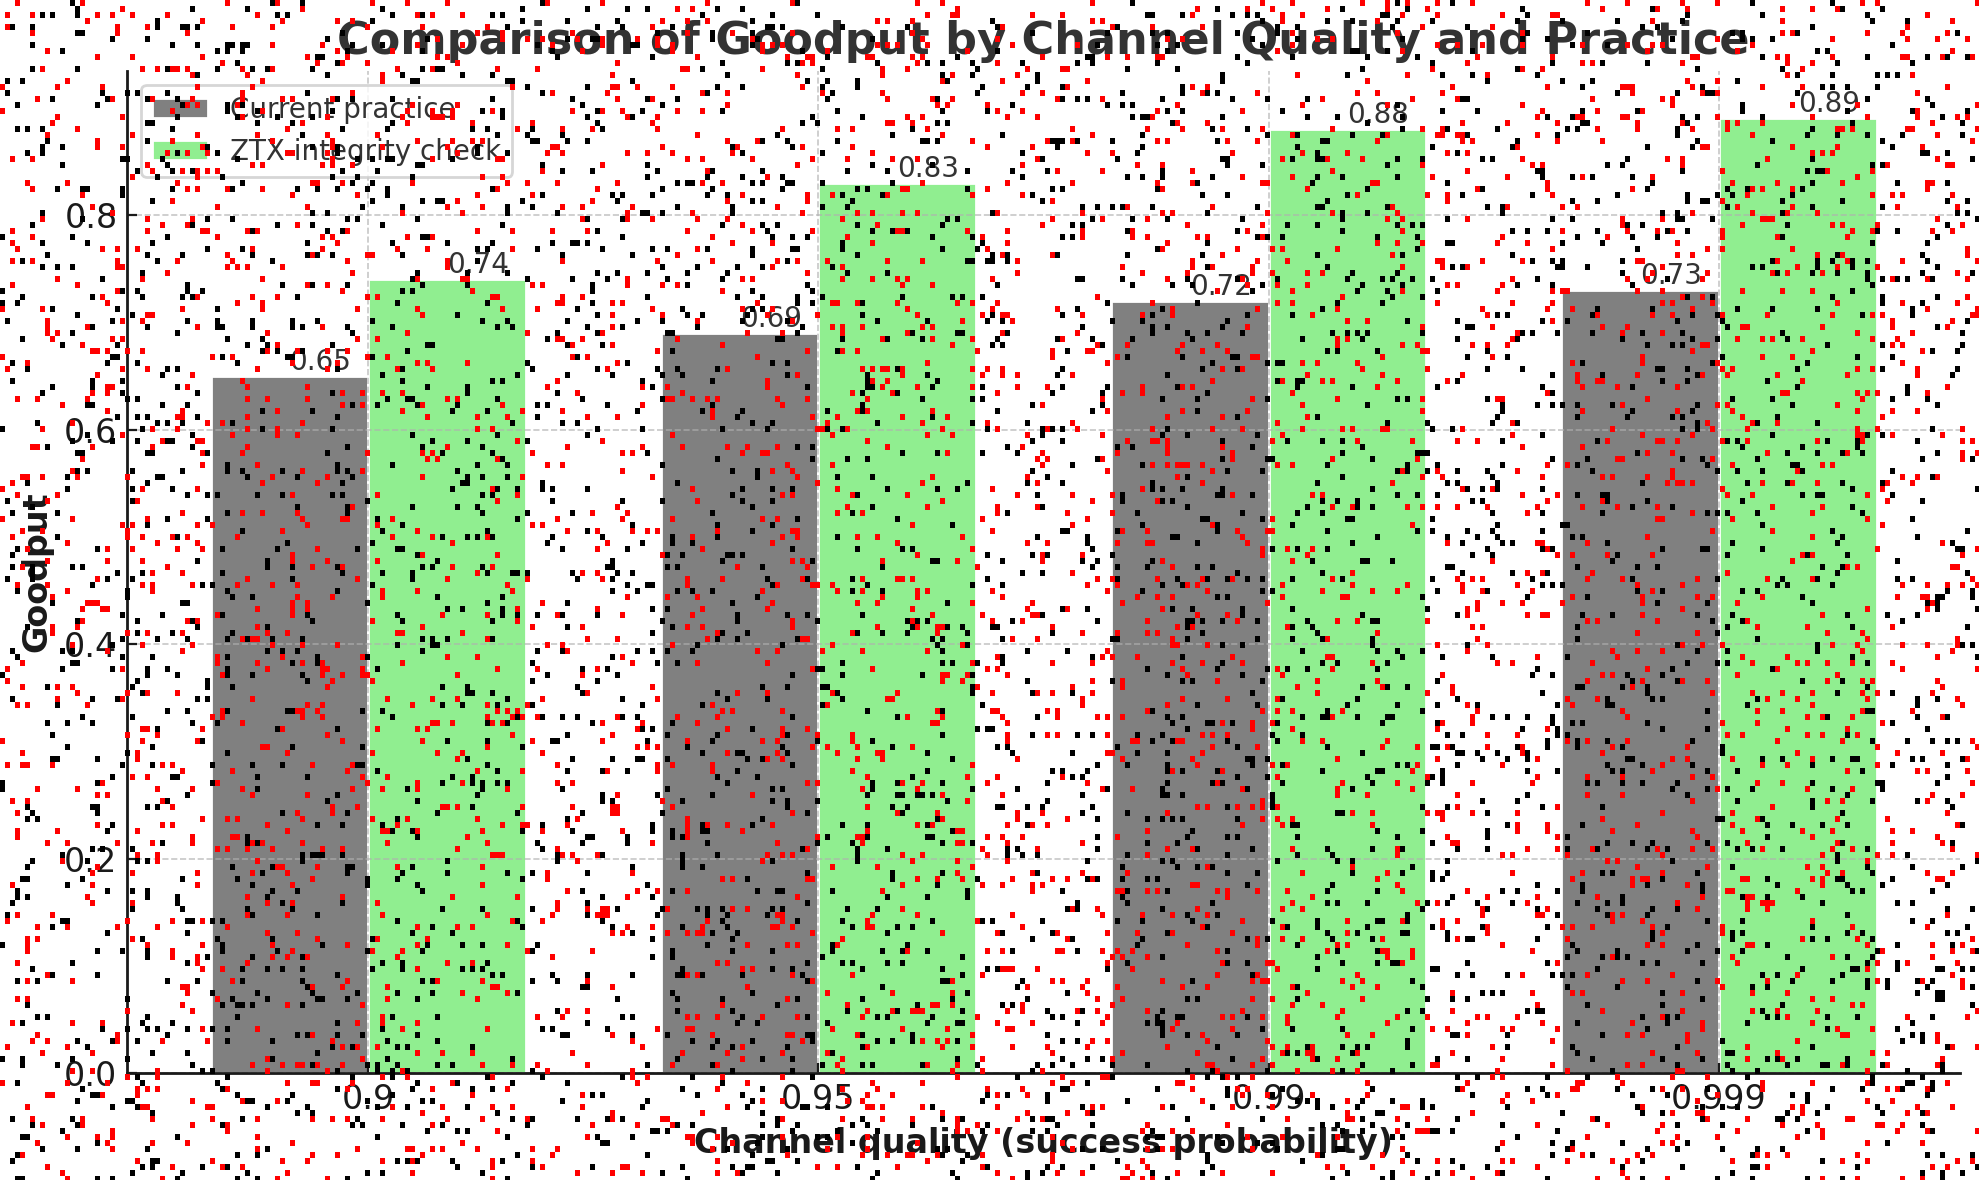

In [3]:
combined_image = combine_pixel_groups_into_image(chunks)
combined_image
